# 1. Introduction

In this work the *Binomial* and *Trinomial* tree techniques for pricing an options are implemented. 

The content of this notebook is as follows:

*   In the second section imported packages are discribed.
*   In the third section the *Binomial tree* approach is implemented. Several examples and solutions to Tutorial 1 are provided as well.
*   In the section 4 the *Binomial tree* approach is implemented.
*   In the last section two approaches are compared in pricing both Vanilla and Barrier Options.

# 2. Importing the packages

In this work the following packages are used:



1.   *matplotlib* - this package provides a visualization of graphics.
2.   *numpy* - this is a classical and one of the most popular packages in Python. It enables to work with different mathematical functions, vectors, matrices and others objects. 
3.   *time* - this package is used to track the running time of algorithms.
4.   *tqdm* - this function from the *tqdm.notebook* package provides a graphical visualisation of running loops.
5.   *Digraph* - this object from the *graphviz* package provides a visualization of directed graphs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

from tqdm.notebook import tqdm as tqdm_
from graphviz import Digraph

The following versions of packages are used:

In [2]:
# import matplotlib, numpy, tqdm, time, graphviz

# print("Used versions:")
# print("matplotlib:", matplotlib.__version__)
# print("numpy:", numpy.__version__)
# print("time: 3.9.1")
# print("tqdm:", tqdm.__version__)
# print("graphviz:", graphviz.__version__)

Used versions:
matplotlib: 3.2.2
numpy: 1.19.5
time: 3.9.1
tqdm: 4.41.1
graphviz: 0.10.1


# 3. Binomial tree pricing

## 3.1 Code part

In [3]:
class Binomial_Tree_Pricing(object):
    '''
    Binomial_Tree_Pricing class is an implementation of Binomial Tree technique 
    for pricing options.
    Current version can calculate the initial price of option for several cases 
    such as stocks with both the fixed and continuous dividend yield, currencies 
    and futures.
    This version can calculate both Vanilla and Barrier options.
    '''
    def __init__(self, cur_pr, strike_pr, r, steps, months=None, sigma=None, 
                 upper_bd=None, lower_bd=None, u=None, d=None, dt=None, r2=0, 
                 D=None, Div_date=None, asset="Stock", udp_str="u=1/d", 
                 opt_mode="European", opt_type="Call"):
      
        '''
        Constructor of the Binomial_Tree_Pricing class.

        Initialization of inputs:
        cur_pr    - current price of the asset.
        strike_pr - strike price of the option.
        r         - annual risk-free rate.
        steps     - number of steps to proceed.
        months    - number of months until the option expires.
        sigma     - volatility parameter.
        upper_bd  - upper bound of the barrier option.
        lower_bd  - lower bound of the barrier option.
        u         - custom increase coefficient of asset price.
        d         - custom decrease coefficient of asset price.
        dt        - custom time of one step in months.
        r2        - continuous dividend yield rate for stocks or 
                    foreign risk-free rate for currencies,
                    default = 0.
        D         - known dividend yield.
        Div_date  - time untill the ex-dividend date in months.
        asset     - name of the asset:
                        "Stock"   - for Stock, default parameter.
                        "Futures" - for Futures, in this case r2 = r.
        udp_str   - strategy for calculating the parameters u, d and p:
                        "u=1/d"  - for this case u = exp(sigma*(dt)^(1/2)),
                                   d = 1/u, p=(exp((r-r2)*dt)-d)/(u-d).
                        "Custom" - for pre-known parameters u and d, 
                                   p=(exp((r-r2)*dt)-d)/(u-d) in this strategy.
                        "p=1/2"  - for this strategy:
                                   u=exp((r-r2)*dt)*(1+(exp((self.sigma^2)*dt)-1)^(1/2)),
                                   d=exp((r-r2)*dt)*(1-(exp((self.sigma^2)*dt)-1)^(1/2)),
                                   p=1/2.
                                   Currently not tested.
                    default is "u=1/d".
        opt_mode  - mode of option:
                        "European" - for European option.
                        "American" - for American option.
                    default is "European".
        opt_type  - type of option:
                        "Call" - for Call option.
                        "Put"  - for Put option.
        
        Initialization of other variables:
        P         - risk-neutral probability.
        opt_price - current price of option. 
        graph     - tree graph with the prices of the option and the underlying asset.
        asset_prs - diagonal matrix of the asset prices, shape:(steps+1, steps+1),
                    asset_prs[i, j] - i-th possible asset price at time j*dt.
        opt_prs   - diagonal matrix of the option prices, shape:(steps+1, steps+1),
                    asset_prs[i, j] - i-th possible option price at time j*dt.
        visited   - diagonal binary matrix for DFS (Depth-first search) algorithm 
                    that indicates whether the algorithm has visited the current 
                    node (i, j) or not.
        '''
        # Check the input values
        assert (asset == "Stock") or (asset == "Futures"), "Check the asset parameter"
        assert (opt_type == "Call") or (opt_type == "Put"), "Check the opt_type parameter"
        assert (udp_str == "Custom") or (udp_str == "u=1/d"), "Check the udp_str parameter"
        assert (udp_str != "p=1/2"), "This strategy is not tested yet, use 'u=1/d' or 'Custom'"
        assert (opt_mode == "European") or (opt_mode == "American"), "Check the opt_mode parameter"
        assert ((D == None) and (Div_date == None)) or ((D != None) and (Div_date != None)), "Check the D and Div_date"
        
        # Initialization of input values
        self.cur_pr = cur_pr
        self.strike_pr = strike_pr
        self.steps = steps
        self.months = months
        self.sigma = sigma
        self.asset = asset
        self.udp_str = udp_str
        self.upper_bd = upper_bd
        self.lower_bd = lower_bd
        self.opt_mode = opt_mode
        self.opt_type = opt_type
        self.r = r
        self.u = u
        self.d = d
        self.D = D
        self.r2 = r  if asset == "Futures" else r2

        # Convert time parameters
        self.dt = dt if dt != None else months / (12 * steps)
        self.Div_date = Div_date / 12 if Div_date != None else None

        # Initialization of other parameters
        self.P = None
        self.opt_price = None
        self.graph = Digraph('tree', strict=True, node_attr={'shape': 'record'})

        # Initialization of matricies, set the nodes at the last step (final nodes) 
        # as visited in the visited matrix
        self.asset_prs = np.zeros((steps + 1, steps + 1))
        self.opt_prs = np.zeros((steps + 1, steps + 1))
        self.visited = np.zeros((steps + 1, steps + 1))
        self.visited[:, -1] = np.ones(steps + 1)


    def reset_visited(self):
        '''
        This function works with the matrix visited.
        It sets the initial values: 
            1 - for the final nodes (j = steps),
            0 - for all other nodes (j < steps).
        '''
        self.visited = np.zeros((self.steps + 1, self.steps + 1))
        self.visited[:, -1] = np.ones(self.steps + 1)


    def plot_graph(self, i=0, j=0):
        '''
        This functions plots the Binomial tree graph with the prices of the 
        option and the underlying asset. DFS algorithm is used for traversing 
        the graph recursively.
        Inputs - matrix indexes of current node (i, j):
        i - i-th current possible price,
        j - j-th current step at time j*dt.
        default (i, j) = (0, 0) - node with the initial (step j=0) asset price.
        '''
        # Prepare the graphical format of the node.
        content = r'{{Asset: %.3f} | Option: %.3f}' % (self.asset_prs[i, j], 
                                                       self.opt_prs[i, j])
        # Create a node
        self.graph.node(f'node {i}, {j}', content)

        # Return if the current node has already been visited
        if self.visited[i, j]:
            return

        # Create two edges from the current node and start the algorithm
        # from these next nodes in a tree
        self.graph.edge(f'node {i}, {j}', f'node {i}, {j + 1}')
        self.graph.edge(f'node {i}, {j}', f'node {i + 1}, {j + 1}')
        self.plot_graph(i, j + 1)
        self.plot_graph(i + 1, j + 1)

        # Label the current node as visited 
        self.visited[i, j] = 1
        return self.graph


    def build_asset_price_mat(self):
        '''
        This function builds the diagonal matrix of possible asset prices - asset_prs.
        The matrix has the following form:
        [S0, S0*u, S0*u^2,  S0*u^3   ... S0*u^(steps)      ]
        [0,  S0*d, S0*u*d,  S0*u^2*d ... S0*u^(steps-1)*d  ]
        [0,  0,    S0*d^2,  S0*u*d^2 ... S0*u^(steps-2)*d^2]
        [0,  0,    0,       S0*d^3   ... S0*u^(steps-3)*d^3]
                                     ...
        [0,  0,    0,       0,       ... S0*d^(steps)      ],
        where S0 - initial (at step j=0) asset price.
        If the known dividend yield D is given at time Div_date, then the matrix has 
        the following form:
        [S0, H*u+D*exp(-r*(Div_date-dt*i)), H*u^2,  H*u^3   ... H*u^(steps)      ]
        [0,  H*d+D*exp(-r*(Div_date-dt*i)), H*u*d,  H*u^2*d ... H*u^(steps-1)*d  ]
        [0,  0,                             H*d^2,  H*u*d^2 ... H*u^(steps-2)*d^2]
        [0,  0,                             0,      H*d^3   ... H*u^(steps-3)*d^3]
                                                            ...
        [0,  0,                             0,      0,      ... H*d^(steps)      ],
        If the Div_date at ------^ (2 <= Div_date <= 3 for this example).
        where H=S0-D*exp(-r*Div_date).
        '''
        # If D is given - subtract the discounted dividend yield from the 
        # initial asset price 
        init_price = self.cur_pr
        if self.D != None:
            init_price -= self.D * np.exp(-self.r * self.Div_date)
        
        # Calculate the possible asset prices in terms of the Binomial model
        for i in range(0, self.steps + 1):
            for j in range(0, i + 1):
                self.asset_prs[j, i] = init_price * self.u**(i - j) * self.d**j
                
                # If D is given - then add the discounted dividend yield to nodes
                # before the Div_date (dt*i <= Div_date)
                if self.D != None and self.dt * i <= self.Div_date:
                    self.asset_prs[j, i] += self.D * np.exp(-self.r * (self.Div_date - self.dt * i))


    def get_price_recursive(self, i=0, j=0):
        '''
        This function implements the DFS algorithm for traversing the graph 
        and calculate the option price recursively.
        Inputs - matrix indexes of node (i, j):
            i - i-th possible price,
            j - j-th step at time j*dt.
            default (i, j) = (0, 0) - node with the initial (step j=0) asset price.
        Outputs:
            price - price of the option in the node (i, j) that corresponds to
                    the asset price (asset_prs[i, j]).
        '''
        # Return if the node (i, j) has already been visited
        if self.visited[i, j]:
            return self.opt_prs[i, j]
        
        # Check whether the upper or lower bounds are given, if so => calculating 
        # the price of barrier option and return 0 as current option price if 
        # the current asset price is out of bounds
        if self.upper_bd != None and self.asset_prs[i, j] >= self.upper_bd:
            return 0
        if self.lower_bd != None and self.asset_prs[i, j] <= self.lower_bd:
            return 0

        # Calculate the expected price in the next step
        expected_pr = self.P * self.get_price_recursive(i, j + 1) + \
                      (1 - self.P) * self.get_price_recursive(i + 1, j + 1)
        
        # Discount the expected price 
        price = expected_pr * np.exp(-self.r * self.dt)
        
        # If the option is American consider the early exercise 
        if self.opt_mode == "American":
            if self.opt_type == "Call":
                price = max(price, self.asset_prs[i, j] - self.strike_pr)
            else:
                price = max(price, self.strike_pr - self.asset_prs[i, j])

        # Store the current option price of node (i, j) in the opt_prs matrix
        self.opt_prs[i, j] = price

        # Label node (i, j) as visited 
        self.visited[i, j] = 1
        return price


    def get_option_price(self, verbose=True):
        '''
        This is the main function of the Binomial_Tree_Pricing class. It calculates 
        the initial price of option for given a set of parameters that were 
        initialized in Constructor.
        Inputs:
        verbose - the binary flag that indicates whether to show the information 
                  of running process or not,
                  default is True. 
        '''
        # Calculate the u and d coefficients if "u=1/d" strategy is set
        if self.udp_str == "u=1/d":
            self.u = np.exp(self.sigma * np.sqrt(self.dt))
            self.d = 1 / self.u
        
        # Calculate the risk-neutral probability
        self.P = (np.exp((self.r - self.r2) * self.dt) - self.d) / (self.u - self.d)

        # Not tested yet
        # elif self.udp_str == "p=1/2":
        
        #    self.u = np.exp((self.r - self.r2) * self.dt) * (1 + np.sqrt(np.exp(self.sigma**2 * self.dt) - 1))
        #    self.d = np.exp((self.r - self.r2) * self.dt) * (1 - np.sqrt(np.exp(self.sigma**2 * self.dt) - 1))
        #    self.P = 1 / 2

        # Check whether the risk-neutral probability is greater than 1
        assert self.P <= 1, "p is greater than 1" 

        # Build the asset prices matrix asset_prs using the function build_asset_price_mat()
        if verbose:
            print("Calculating the asset prices...")
        self.build_asset_price_mat()

        # Calculate the option prices at the last step (j=steps)
        if self.opt_type == "Call":
            self.opt_prs[:, -1] = self.asset_prs[:, -1] - self.strike_pr
            self.opt_prs[self.opt_prs < 0] = 0
        else:
            self.opt_prs[:, -1] = self.strike_pr - self.asset_prs[:, -1]
            self.opt_prs[self.opt_prs < 0] = 0
        
        # Check whether the upper and lower bounds are given, if so => calculating 
        # the price of barrier option and set 0 as the option price if the asset 
        # price is out of bounds
        if self.upper_bd != None: 
            self.opt_prs[self.asset_prs >= self.upper_bd] = 0
        if self.lower_bd != None:
            self.opt_prs[self.asset_prs <= self.lower_bd] = 0
        
        # Calculate the initial option price for node (0, 0)
        if verbose:
            print("Calculating the option prices...")
        self.opt_price = self.get_price_recursive()

        # Reset the visited matrix for further graph plotting
        self.reset_visited()

        if verbose:
            print("Succeed.")

## 3.2 Examples

Let us provide several simple examples of *Binomial_tree_pricing* class usage. More complpicated cases such as stocks with both the fixed and continuous dividend yield, currencies and futures are considered in the Tutorialsolutions.

### Example 1

*Options, Futures and other Derivatives*, 10-th ed., ch.13, p.278.

---

Let a stock price be currently \$20. Let's value a European 6-month call option with a strike price of \$21 using a two-step tree. Risk-free interest rate is 4% per annum. In each step the price may go up by 10% or down by 10%.


In [4]:
# First let's define the given parameters
cur_price = 20
strike_price = 21
r = 0.04
months = 6
steps = 2

# For this example the coefficients u and d are given => set the 'Custom' strategy
udp_str = "Custom"
u = 1.1
d = 0.9

# Create an object of Binomial_Tree_Pricing class with given parameters
bin_tree_ex1 = Binomial_Tree_Pricing(cur_pr=cur_price, strike_pr=strike_price,
                                     r=r, steps=steps, months=months, 
                                     udp_str=udp_str, u=u, d=d)

# Calculate the option price 
bin_tree_ex1.get_option_price()

Calculating the asset prices...
Calculating the option prices...
Succeed.


In [5]:
# All parameters of the Binomial_Tree_Pricing class are available via . and name of the parameter
# For example, the let's get the initial option price
bin_tree_ex1.opt_price

0.9496979703975418

In [6]:
# Let's get the matrix of asset prices
bin_tree_ex1.asset_prs

array([[20. , 22. , 24.2],
       [ 0. , 18. , 19.8],
       [ 0. ,  0. , 16.2]])

In [7]:
# Let's get the risk-neutral probability
bin_tree_ex1.P

0.5502508354208394

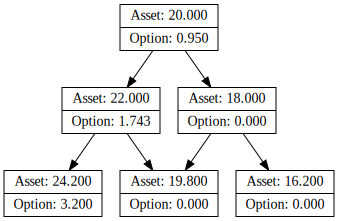

In [8]:
# Let's build the tree graph
bin_tree_ex1.plot_graph()

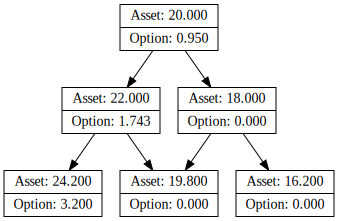

In [9]:
# Once the graph is build using the plot_graph() function, it is stored in the
# graph parameter
bin_tree_ex1.graph

### Example 2

*Options, Futures and other Derivatives*, 10-th ed., ch.13, p.281.

---

Consider a 2-year European put with a strike price of \$52 on a stock whose current price is \$50. We suppose that there are two time steps of 1 year, and in each time step the stock price either moves up by 20% or moves down by 20%. We also suppose that the risk-free interest rate is 5%.

In [10]:
# We can also define parameters in dictionary

params_ex2 = {"cur_pr"       : 50,
              "strike_pr"    : 52,
              "r"            : 0.05,
              "months"       : 12 * 2,
              "steps"        : 2,
              "udp_str"      : "Custom",
              "u"            : 1.2,
              "d"            : 0.8,
              "opt_type"     : "Put"}

bin_tree_ex2 = Binomial_Tree_Pricing(**params_ex2)

# We can hide the additional information
bin_tree_ex2.get_option_price(verbose=False)

# Let's get the option price
bin_tree_ex2.opt_price

4.1926542806038585

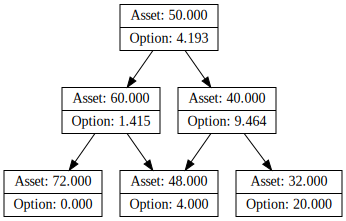

In [11]:
# Let's plot the tree graph
bin_tree_ex2.plot_graph()

Let's consider the American option with the same parameters.

In [12]:
params_ex2["opt_mode"] = "American"
bin_tree_ex2 = Binomial_Tree_Pricing(**params_ex2)
bin_tree_ex2.get_option_price(verbose=False)
bin_tree_ex2.opt_price

5.089632474198373

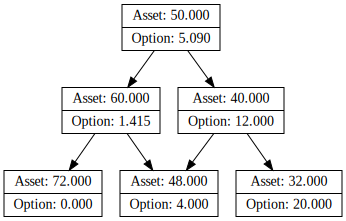

In [13]:
bin_tree_ex2.plot_graph()

### Example 3

*Options, Futures and other Derivatives*, 10-th ed., ch.13, p.286.

---

Let's consider the parameters from the previous example with the strategy 'u=1/d' for American put option with the volatility $\sigma$ is 30%.

In [14]:
params_ex3 = {"cur_pr"    : 50,
              "strike_pr" : 52,
              "r"         : 0.05,
              "months"    : 12 * 2,
              "sigma"     : 0.3,
              "steps"     : 2,
              "opt_mode"  : "American",
              "opt_type"  : "Put"}

bin_tree_ex3 = Binomial_Tree_Pricing(**params_ex3)
bin_tree_ex3.get_option_price(verbose=False)
bin_tree_ex3.opt_price

7.428401902704835

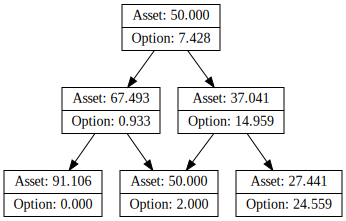

In [15]:
bin_tree_ex3.plot_graph()

## 3.3 Tutorial1 solutions

### Q.1

*Options, Futures and other Derivatives*, 10-th ed., ch.21, p.462, ex. 21.5.

---

Use a two-step binomial tree to price of a 5-month American put option on a stock. The stock is expected to pay dividends of $2 per share at the third month. The current stock price is \$52, the exercise price is \$50, the risk-free interest rate is 10% per annum. Assume that the volatility of the part of the stock price that will not be used to pay the dividends is 40% per annum. 

In [16]:
params_q1 = {"cur_pr"    : 52,
             "strike_pr" : 50,
             "r"         : 0.1,
             "months"    : 5,
             "steps"     : 5,
             "sigma"     : 0.4,
             "D"         : 2.06,  # set the dividends per share
             "Div_date"  : 3.5,   # set the ex-dividend date in months
             "opt_mode"  : "American",
             "opt_type"  : "Put"}


bin_tree_q1 = Binomial_Tree_Pricing(**params_q1)
bin_tree_q1.get_option_price()

Calculating the asset prices...
Calculating the option prices...
Succeed.


In [17]:
bin_tree_q1.opt_price

4.440359507693445

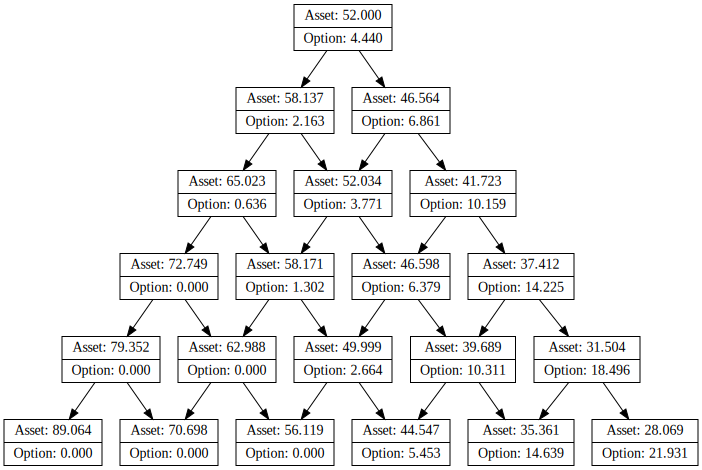

In [18]:
bin_tree_q1.plot_graph()

### Q.2

*Options, Futures and other Derivatives*, 10-th ed., ch.13, p.289, ex. 13.1.

---

A stock index is currently 810 and has a volatility of 20% and a dividend yield of 2%. The riskfree rate is 5%. Value a European 6-month call option with a strike price of 800 using a two-step tree.

In [19]:
params_q2 = {"cur_pr"    : 810,
             "strike_pr" : 800,
             "r"         : 0.05,
             "r2"        : 0.02, # set the continuous dividend yield
             "months"    : 6,
             "steps"     : 2,
             "sigma"     : 0.2}

bin_tree_q2 = Binomial_Tree_Pricing(**params_q2)
bin_tree_q2.get_option_price(verbose=False)
bin_tree_q2.opt_price

53.39471637496134

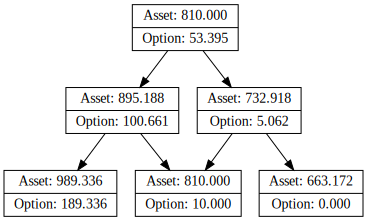

In [20]:
bin_tree_q2.plot_graph()

### Q.3

*Options, Futures and other Derivatives*, 10-th ed., ch.13, p.290, ex. 13.2.

---

The Australian dollar is currently worth 0.61 US dollars and this exchange rate has a volatility of 12%. The Australian risk-free rate is 7% and the US risk-free rate is 5%. Use a 3-step tree to value a 3-month American call option with a strike price of 0.6.

In [21]:
params_q3 = {"cur_pr"    : 0.61, # set the current currency 
             "strike_pr" : 0.60, # set the strike currency 
             "r"         : 0.05, # set the domestic risk-free rate (US)
             "r2"        : 0.07, # set the foreign risk-free rate (Australia)
             "months"    : 3,
             "steps"     : 3,
             "sigma"     : 0.12,
             "opt_mode"  : "American"}

bin_tree_q3 = Binomial_Tree_Pricing(**params_q3)
bin_tree_q3.get_option_price(verbose=False)
bin_tree_q3.opt_price

0.01888057792230972

### Q.4

*Options, Futures and other Derivatives*, 10-th ed., ch.13, p.291, ex. 13.3.

---

A futures price is currently 31 and has a volatility of 30%. The risk-free rate is 5%. Use a three-step binomial tree to value a 9-month American put option with a strike price of 30. 

In [22]:
# 1-st way

params_q4 = {"cur_pr"    : 31,
             "strike_pr" : 30,
             "r"         : 0.05,
             "months"    : 9,
             "steps"     : 3,
             "sigma"     : 0.3,
             "asset"     : "Futures",
             "opt_mode"  : "American",
             "opt_type"  : "Put"}

bin_tree_q4 = Binomial_Tree_Pricing(**params_q4)
bin_tree_q4.get_option_price(verbose=False)
bin_tree_q4.opt_price

2.8356351571052616

In [23]:
# 2-nd way

params_q4 = {"cur_pr"    : 31,
             "strike_pr" : 30,
             "r"         : 0.05,
             "r2"        : 0.05, # set the same value for r
             "months"    : 9,
             "steps"     : 3,
             "sigma"     : 0.3,
             "opt_mode"  : "American",
             "opt_type"  : "Put"}

bin_tree_q4 = Binomial_Tree_Pricing(**params_q4)
bin_tree_q4.get_option_price(verbose=False)
bin_tree_q4.opt_price

2.8356351571052616

### Q.6

A stock price is currently \$50. It is known that during each 6 month period for the next year it will increase by 20% or reduce by 16%. Consider a call option on a non-dividendpaying stock with the strike price is \$48. The risk-free rate is 12% per annum.

#### A

Use a one-step tree to price a 6-month European option.

In [24]:
params_q6 = {"cur_pr"    : 50,
             "strike_pr" : 48,
             "r"         : 0.12,
             "months"    : 6,
             "steps"     : 1,
             "udp_str"   : "Custom",
             "u"         : 1.2,
             "d"         : 0.84}

bin_tree_q6 = Binomial_Tree_Pricing(**params_q6)
bin_tree_q6.get_option_price(verbose=False)
bin_tree_q6.opt_price

6.963926392974371

#### B

Use a two-step tree to price a 1-year American option.

In [25]:
params_q6 = {"cur_pr"    : 50,
             "strike_pr" : 48,
             "r"         : 0.12,
             "months"    : 12,
             "steps"     : 2,
             "udp_str"   : "Custom",
             "u"         : 1.2,
             "d"         : 0.84,
             "opt_mode"  : "American"}

bin_tree_q6 = Binomial_Tree_Pricing(**params_q6)
bin_tree_q6.get_option_price(verbose=False)
bin_tree_q6.opt_price

9.089520997459823

### Q.7

A currency is currently worth \$0.80 and has a volatility of 12%. The domestic and foreign risk-free interest rates are 6% and 8%, respectively.

#### A

Use a two-step binomial tree to value a European four-month call option with a strike price of $0.79.

In [26]:
params_q7 = {"cur_pr"    : 0.80,
             "strike_pr" : 0.79,
             "r"         : 0.06,
             "r2"        : 0.08,
             "sigma"     : 0.12,
             "months"    : 4,
             "steps"     : 2}

bin_tree_q7 = Binomial_Tree_Pricing(**params_q7)
bin_tree_q7.get_option_price(verbose=False)
bin_tree_q7.opt_price

0.023501441082653417

#### B

Use a two-step binomial tree to value an American four-month call option with the same strike price.

In [27]:
params_q7["opt_mode"] = "American"

bin_tree_q7 = Binomial_Tree_Pricing(**params_q7)
bin_tree_q7.get_option_price(verbose=False)
bin_tree_q7.opt_price

0.024969382683209095

### Q.8

Use a three-step binomial tree to calculate the value of a three-month at-the-money European call option on a stock index when the index is at 250, the risk-free interest rate is 10% per annum, the volatility of the index is 18% per annum, and the dividend yield on the index is 3% per annum.

In [28]:
params_q8 = {"cur_pr"    : 250,
             "strike_pr" : 250,
             "r"         : 0.10,
             "r2"        : 0.03,
             "sigma"     : 0.18,
             "months"    : 3,
             "steps"     : 3}

bin_tree_q8 = Binomial_Tree_Pricing(**params_q8)
bin_tree_q8.get_option_price(verbose=False)
bin_tree_q8.opt_price

11.85474106499492

# 4. Trinomial tree pricing

## 4.1 Code part

In [29]:
class Trinomial_Tree_Pricing(object):
    '''
    Trinomial_Tree_Pricing class is an implementation of Trinomial Tree technique 
    for pricing options.
    Current version is implemented only for Stocks (with continuous dividend yield) 
    and only with 'u=1/d' strategy.
    This version can calculate both Vanilla and Barrier options.
    '''
    def __init__(self, cur_pr, strike_pr, r, steps, months=None, sigma=None, 
                 upper_bd=None, lower_bd=None, dt=None, r2=0, 
                 opt_mode="European", opt_type="Call"):
        '''
        Constructor of the Binomial_Tree_Pricing class.

        Initialization of inputs:
        cur_pr    - current price of the asset.
        strike_pr - strike price of the option.
        r         - annual risk-free rate.
        steps     - number of steps to proceed.
        months    - number of months until the option expires.
        sigma     - volatility parameter.
        upper_bd  - upper bound of the barrier option.
        lower_bd  - lower bound of the barrier option.
        dt        - custom time of one step in months.
        r2        - continuous dividend yield rate for stocks or 
                    foreign risk-free rate for currencies,
                    default = 0.
        opt_mode  - mode of option:
                        "European" - for European option.
                        "American" - for American option.
                    default is "European".
        opt_type  - type of option:
                        "Call" - for Call option.
                        "Put"  - for Put option.
        
        Initialization of other variables:
        Pu        - risk-neutral probability of upward move of asset price.
        Pm        - risk-neutral probability of staying in the same node.
        Pd        - risk-neutral probability of downward move of asset price.
        opt_price - current price of option. 
        graph     - tree graph with the prices of the option and the underlying asset.
        asset_prs - diagonal matrix of the asset prices, shape:(steps+1, steps+1),
                    asset_prs[i, j] - i-th possible asset price at time j*dt.
        opt_prs   - diagonal matrix of the option prices, shape:(steps+1, steps+1),
                    asset_prs[i, j] - i-th possible option price at time j*dt.
        visited   - diagonal binary matrix for DFS (Depth-first search) algorithm 
                    that indicates whether the algorithm has visited the current 
                    node (i, j) or not.
        '''
        # Check the input values
        assert (opt_type == "Call") or (opt_type == "Put"), "Check the opt_type parameter"
        assert (opt_mode == "European") or (opt_mode == "American"), "Check the opt_mode parameter"

        # Initialization of input values
        self.cur_pr = cur_pr
        self.strike_pr = strike_pr
        self.steps = steps
        self.months = months
        self.sigma = sigma
        self.upper_bd = upper_bd
        self.lower_bd = lower_bd
        self.opt_mode = opt_mode
        self.opt_type = opt_type
        self.r = r
        self.r2 = r2

        # Convert time parameters
        self.dt = dt if dt != None else months / (12 * steps)

        # Initialization of other parameters
        self.Pu = None
        self.Pm = None
        self.Pd = None
        self.opt_price = None
        self.graph = Digraph('tree', strict=True, node_attr={'shape': 'record'})

        # Initialization of matricies, set the nodes at the last step (final nodes) 
        # as visited in the visited matrix
        self.asset_prs = np.zeros((2 * steps + 1, steps + 1))
        self.opt_prs = np.zeros((2 * steps + 1, steps + 1))
        self.visited = np.zeros((2 * steps + 1, steps + 1))
        self.visited[:, -1] = np.ones(2 *steps + 1)
        
    
    def reset_visited(self):
        '''
        This function works with the matrix visited.
        It sets the initial values: 
            1 - for the final nodes (j = steps),
            0 - for all other nodes (j < steps).
        '''
        self.visited = np.zeros((2 * self.steps + 1, self.steps + 1))
        self.visited[:, -1] = np.ones(2 * self.steps + 1)


    def plot_graph(self, i=0, j=0):
        '''
        This functions plots the Binomial tree graph with the prices of the 
        option and the underlying asset. DFS algorithm is used for traversing 
        the graph recursively.
        Inputs - matrix indexes of current node (i, j):
        i - i-th current possible price,
        j - j-th current step at time j*dt.
        default (i, j) = (0, 0) - node with the initial (step j=0) asset price.
        '''
        # Prepare the graphical format of the node.
        content = r'{{Asset: %.3f} | Option: %.3f}' % (self.asset_prs[i, j], 
                                                       self.opt_prs[i, j])
        # Create a node
        self.graph.node(f'node {i}, {j}', content)

        # Return if the current node has already been visited
        if self.visited[i, j]:
            return

        # Create three edges from the current node and start the algorithm
        # from these next nodes in a tree
        self.graph.edge(f'node {i}, {j}', f'node {i}, {j + 1}')
        self.graph.edge(f'node {i}, {j}', f'node {i + 1}, {j + 1}')
        self.graph.edge(f'node {i}, {j}', f'node {i + 2}, {j + 1}')
        self.plot_graph(i, j + 1)
        self.plot_graph(i + 1, j + 1)
        self.plot_graph(i + 2, j + 1)

        # Label the current node as visited 
        self.visited[i, j] = 1
        return self.graph


    def build_asset_price_mat(self):
        '''
        This function builds the diagonal matrix of possible asset prices - asset_prs.
        The matrix has the following form:
        [S0, S0*u, S0*u^2, ... S0*u^(2*steps)  ]
        [0,  S0  , S0*u,   ... S0*u^(2*steps-1)]
        [0,  S0*d, S0,     ... S0*u^(2*steps-2)]
        [0,  0,    S0*d,   ... S0*u^(2*steps-3)]
        [0,  0,    S0*d^2, ... S0*u^(2*steps-4)]
                           ...
        [0,  0,    0,      ... S0*d^(2*steps)  ],
        where S0 - initial (at step j=0) asset price.
        '''
        # Calculate the possible asset prices in terms of the Trinomial model
        for i in range(0, self.steps + 1):
            for j in range(0, 2 * i + 1):
                self.asset_prs[j, i] = self.cur_pr * self.u**(max(i - j, 0)) * self.d**(max(j - i, 0))


    def get_price_recursive(self, i=0, j=0):
        '''
        This function implements the DFS algorithm for traversing the graph 
        and calculate the option price recursively.
        Inputs - matrix indexes of node (i, j):
            i - i-th possible price,
            j - j-th step at time j*dt.
            default (i, j) = (0, 0) - node with the initial (step j=0) asset price.
        Outputs:
            price - price of the option in the node (i, j) that corresponds to
                    the asset price (asset_prs[i, j]).
        '''
        # Return if the node (i, j) has already been visited
        if self.visited[i, j]:
            return self.opt_prs[i, j]

        # Check whether the upper or lower bounds are given, if so => calculating 
        # the price of barrier option and return 0 as current option price if 
        # the current asset price is out of bounds
        if self.upper_bd != None and self.asset_prs[i, j] >= self.upper_bd:
            return 0
        if self.lower_bd != None and self.asset_prs[i, j] <= self.lower_bd:
            return 0

        # Calculate the expected price in the next step
        expected_pr = self.Pu * self.get_price_recursive(i, j + 1) + \
                      self.Pm * self.get_price_recursive(i + 1, j + 1) + \
                      self.Pd * self.get_price_recursive(i + 2, j + 1)

        # Discount the expected price
        price = expected_pr * np.exp(-self.r * self.dt)

        # If the option is American consider the early exercise 
        if self.opt_mode == "American":
            if self.opt_type == "Call":
                price = max(price, self.asset_prs[i, j] - self.strike_pr)
            else:
                price = max(price, self.strike_pr - self.asset_prs[i, j])
        
        # Store the current option price of node (i, j) in the opt_prs matrix
        self.opt_prs[i, j] = price

        # Label node (i, j) as visited 
        self.visited[i, j] = 1
        return price


    def get_option_price(self, verbose=True):
        '''
        This is the main function of the Binomial_Tree_Pricing class. It calculates 
        the initial price of option for given a set of parameters that were 
        initialized in Constructor.
        Inputs:
        verbose - the binary flag that indicates whether to show the information 
                  of running process or not,
                  default is True. 
        '''
        # Calculate the u and d coefficients
        self.u = np.exp(self.sigma * np.sqrt(2 * self.dt))
        self.d = 1 / self.u

        # Calculate the risk-neutral probabilities
        pos_exp = np.exp(self.sigma * np.sqrt(self.dt / 2))
        neg_exp = np.exp(-self.sigma * np.sqrt(self.dt / 2))
        self.Pu = ((np.exp((self.r - self.r2) * self.dt / 2) - neg_exp) / (pos_exp - neg_exp))**2
        self.Pd = ((pos_exp - np.exp((self.r - self.r2) * self.dt / 2)) / (pos_exp - neg_exp))**2
        self.Pm = 1 - self.Pu - self.Pd

        # Check whether the risk-neutral sum of probabilities is greater than 1
        assert (self.Pu + self.Pd <= 1), "Pu + Pd is greater than 1"

        # Build the asset prices matrix asset_prs using the function build_asset_price_mat()
        if verbose:
            print("Calculating the asset prices...")
        self.build_asset_price_mat()

        # Calculate the option prices at the last step (j=steps)
        if self.opt_type == "Call":
            self.opt_prs[:, -1] = self.asset_prs[:, -1] - self.strike_pr
            self.opt_prs[self.opt_prs < 0] = 0
        else:
            self.opt_prs[:, -1] = self.strike_pr - self.asset_prs[:, -1]
            self.opt_prs[self.opt_prs < 0] = 0

        # Check whether the upper and lower bounds are given, if so => calculating 
        # the price of barrier option and set 0 as the option price if the asset 
        # price is out of bounds
        if self.upper_bd != None:
            self.opt_prs[self.asset_prs >= self.upper_bd] = 0
        if self.lower_bd != None:
            self.opt_prs[self.asset_prs <= self.lower_bd] = 0

        # Calculate the initial option price for node (0, 0)
        if verbose:
            print("Calculating the option prices...")
        self.opt_price = self.get_price_recursive()

        # Reset the visited matrix for further graph plotting
        self.reset_visited()

        if verbose:
            print("Succeed.")

## 4.2 Simple example

*Trinomial_Tree_Pricing* class has the same functions as the *Binomial_Tree_Pricing* class, hence the usage of these classes is identical. Let's consider both cases in the following example (Example 3):

Consider a 2-year American put with a strike price of \$52 on a stock whose current price is \$50. We suppose that there are two time steps of 1 year, and in each time step the stock price either moves up by 20% or moves down by 20%. We also suppose that the risk-free interest rate is 5%.

In [30]:
# Binomial 

params_ex3 = {"cur_pr"    : 50,
              "strike_pr" : 52,
              "r"         : 0.05,
              "months"    : 12 * 2,
              "sigma"     : 0.3,
              "steps"     : 2,
              "opt_mode"  : "American",
              "opt_type"  : "Put"}

bin_tree_ex3 = Binomial_Tree_Pricing(**params_ex3)
bin_tree_ex3.get_option_price(verbose=False)
bin_tree_ex3.opt_price

7.428401902704835

In [31]:
# Trinomial 

tri_tree_ex3 = Trinomial_Tree_Pricing(**params_ex3)
tri_tree_ex3.get_option_price(verbose=False)
tri_tree_ex3.opt_price

7.1613492172725834

Let's compare the graphs.

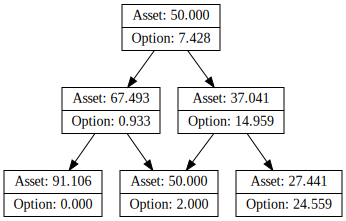

In [32]:
bin_tree_ex3.plot_graph()

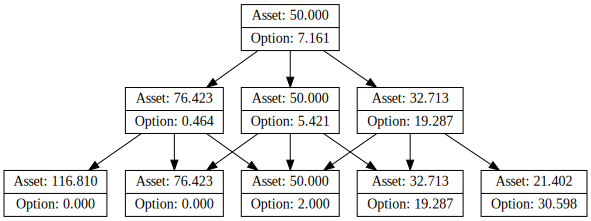

In [33]:
tri_tree_ex3.plot_graph()

# 5. Comparison

## 5.1 Vanilla options 

Let's compare the rate and time to convergence for pricing the *'Vanilla'* option for the range of steps from 1 to 50. European 6-month Call option with the strike price \$51 will be considered as an example. Risk-free rate=5%, $\sigma$=30% and current price of the stock is \$50.

In [34]:
params_comp = {"cur_pr"    : 50,
               "strike_pr" : 51,
               "months"    : 6,
               "r"         : 0.05,
               "sigma"     : 0.3}

bin_prices = []
tri_prices = []
bin_time = []
tri_time = []
max_num_steps = 50

for steps in tqdm_(range(1, max_num_steps + 1)):
    params_comp["steps"] = steps

    begin = time.time()
    bin_tree_pr = Binomial_Tree_Pricing(**params_comp)
    bin_tree_pr.get_option_price(verbose=False)
    total = time.time() - begin
    bin_time.append(total)

    begin = time.time()
    tri_tree_pr = Trinomial_Tree_Pricing(**params_comp)
    tri_tree_pr.get_option_price(verbose=False)
    total = time.time() - begin
    tri_time.append(total)

    bin_prices.append(bin_tree_pr.opt_price)
    tri_prices.append(tri_tree_pr.opt_price)

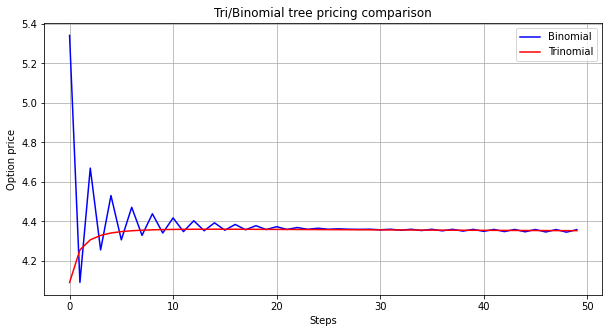

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(max_num_steps), bin_prices, c="blue", label="Binomial")
plt.plot(np.arange(max_num_steps), tri_prices, c="red", label="Trinomial")
plt.title("Tri/Binomial tree pricing comparison")
plt.xlabel("Steps")
plt.ylabel("Option price")
plt.legend()
plt.grid()
plt.show()

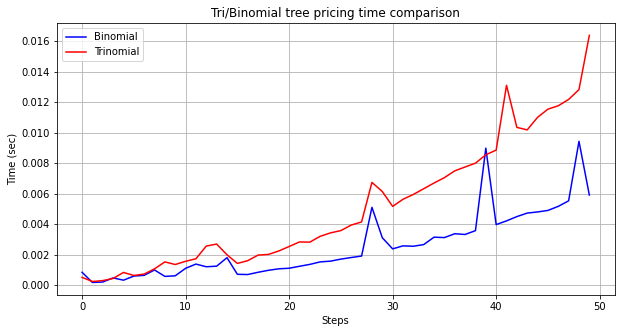

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(max_num_steps), bin_time, c="blue", label="Binomial")
plt.plot(np.arange(max_num_steps), tri_time, c="red", label="Trinomial")
plt.title("Tri/Binomial tree pricing time comparison")
plt.xlabel("Steps")
plt.ylabel("Time (sec)")
plt.legend()
plt.grid()
plt.show()

It can be seen from the graphics above that the *Trinomial* approach has greater convergence rate, however, it takes more computational time than the *Binomial* approach as the number of steps increases.

## 5.2 Barrier option

Let's compare both approaches for pricing the barrier options for the following task:

Use the *Trinomial* tree model to price double barrier knock-out European call and put options based on upper and lower barriers of \\$130 and \\$60 respectively for the set of initial prices \\$60 < S(0) < \\$130 used to price ‘vanilla’ European options. Use the following parameters K=\$90, T=0.5, r=5%, $\sigma$=20%. Set the total number of steps N=50. Plot option prices as a function of the initial price S(0).

In [37]:
params_comp_bar = {"cur_pr"    : 95,
                   "strike_pr" : 90,
                   "dt"        : 0.5 / 50,
                   "r"         : 0.05,
                   "sigma"     : 0.2,
                   "steps"     : 50,
                   "upper_bd"  : 130,
                   "lower_bd" : 60}

bin_tree_pr = Binomial_Tree_Pricing(**params_comp_bar)
bin_tree_pr.get_option_price(verbose=False)

tri_tree_pr = Trinomial_Tree_Pricing(**params_comp_bar)
tri_tree_pr.get_option_price(verbose=False)

In [38]:
# Binomial tree price
bin_tree_pr.opt_price

8.32927869499042

In [39]:
# Trinomial tree price
tri_tree_pr.opt_price

8.631544187342566

In [40]:
cur_prices = np.arange(60, 131, 0.5)
bin_prices = []
tri_prices = []

for price in tqdm_(cur_prices):
    params_comp_bar["cur_pr"] = price

    bin_tree_pr = Binomial_Tree_Pricing(**params_comp_bar)
    bin_tree_pr.get_option_price(verbose=False)
    bin_prices.append(bin_tree_pr.opt_price)

    tri_tree_pr = Trinomial_Tree_Pricing(**params_comp_bar)
    tri_tree_pr.get_option_price(verbose=False)
    tri_prices.append(tri_tree_pr.opt_price)

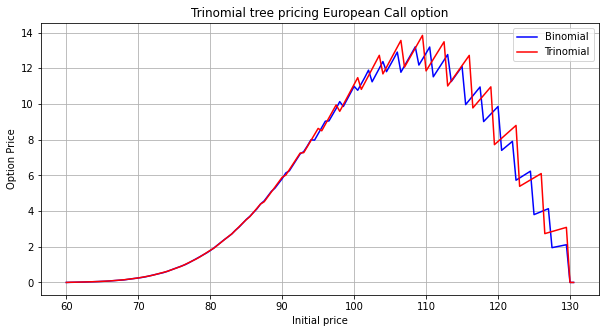

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(cur_prices, bin_prices, c="blue", label="Binomial")
plt.plot(cur_prices, tri_prices, c="red", label="Trinomial")
plt.title("Trinomial tree pricing European Call option")
plt.xlabel("Initial price")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.show()

In [42]:
params_comp_bar["opt_type"] = "Put"
bin_prices = []
tri_prices = []


for price in tqdm_(cur_prices):
    params_comp_bar["cur_pr"] = price

    bin_tree_pr = Binomial_Tree_Pricing(**params_comp_bar)
    bin_tree_pr.get_option_price(verbose=False)
    bin_prices.append(bin_tree_pr.opt_price)

    tri_tree_pr = Trinomial_Tree_Pricing(**params_comp_bar)
    tri_tree_pr.get_option_price(verbose=False)
    tri_prices.append(tri_tree_pr.opt_price)

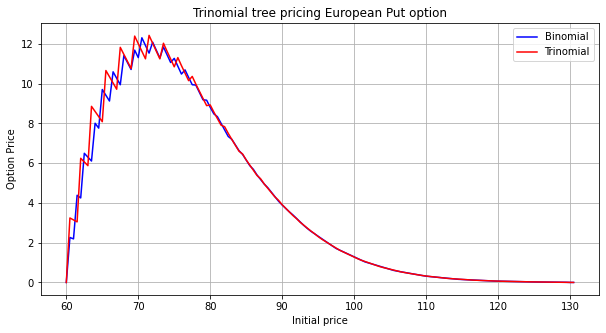

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(cur_prices, bin_prices, c="blue", label="Binomial")
plt.plot(cur_prices, tri_prices, c="red", label="Trinomial")
plt.title("Trinomial tree pricing European Put option")
plt.xlabel("Initial price")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.show()

Both approaches show roughly the same change in the option price as the stock price changes for both Put and Call types.